In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras.models import load_model
from PIL import Image
import cv2

import os

In [2]:
images_dir = "C:/Users/ArrunPersonal/Desktop/RG_MiniProject/PHOTOS_FOG_final/"
annot_dir = "C:/Users/ArrunPersonal/Desktop/RG_MiniProject/JSON_final/"

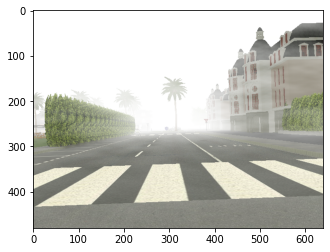

{'xMin': 303.41707747495207,
 'yMin': 260.70168963268503,
 'width': 25.366236707904854,
 'height': 6.975715094673835}

In [3]:
os.chdir(images_dir)
index = 20
name = str(os.listdir(annot_dir)[20])
plt.imshow(plt.imread(name.split('.')[0]+".png"))
plt.show()
os.chdir(annot_dir)
js = pd.read_json(name)
js['rectMask'][0]

In [4]:
all_images = []
all_labels = []
for i in range(len(os.listdir(annot_dir))):
    #print(os.listdir(annot_dir)[i])
    ## Reading image, resizing it to desired size and appending to all_images
    image_name = str(os.listdir(annot_dir)[i].split('.')[0])
    #print(image_name,os.listdir(annot_dir)[i])
    name = images_dir + image_name+".png"
    os.chdir(images_dir)
    img = plt.imread(name)
    present_shape = np.shape(img)
    desired_shape = 256
    factor = [present_shape[1]/desired_shape,present_shape[0]/desired_shape]
    
    ## reading json, storing annotations to nested list after scaling labels
    os.chdir(annot_dir)
    js = pd.read_json(os.listdir(annot_dir)[i])
    inst_labels = []
    flag = 0
    for j in range(len(js)):
        label = dict(js['labels'][j])['labelName']
        
        if(label == 'Car'):
        # if(i<10):
        #     print(f"""Values before scaling: {list(dict(js['rectMask'][j]).values())}\n
        #               Scaling factor = {np.array(factor*2)} 
        #               Values after scaling : {list(dict(js['rectMask'][j]).values())/np.array(factor*2)}""")
            flag = 1
            xMin,yMin,Width,Height = np.array(list(dict(js['rectMask'][j]).values()))/np.array(factor*2)
            inst_labels.append([label,int(xMin),int(Width)+int(xMin),int(yMin),int(yMin)+int(Height)])
    if(flag):
        all_images.append(cv2.resize(img,(desired_shape,desired_shape)))
        all_labels.append(inst_labels)

In [5]:
all_labels[22]

[['Car', 104, 126, 136, 146],
 ['Car', 163, 178, 134, 143],
 ['Car', 151, 163, 135, 143]]

In [6]:
items = set()
for i in range(len(all_labels)):
    for j in range(len(all_labels[i])):
        items.add(all_labels[i][j][0])

In [7]:
label_dict = dict(zip(list(items),np.arange(len(list(items)))))
get_key_dict = dict(zip(np.arange(len(list(items))),list(items)))
label_dict['BG'] = len(label_dict)
get_key_dict[len(get_key_dict)] = 'BG'

In [8]:
label_dict

{'Car': 0, 'BG': 1}

(166, 136) (178, 143)
(151, 136) (162, 144)
(104, 137) (128, 147)
[['Car', 166, 178, 136, 143], ['Car', 151, 162, 136, 144], ['Car', 104, 128, 137, 147]]


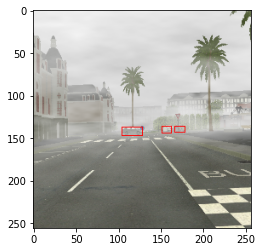

(83, 137) (94, 146)
[['Car', 83, 94, 137, 146]]


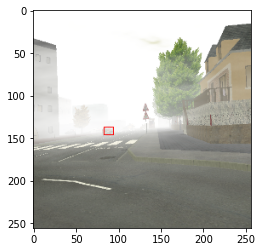

(151, 136) (162, 143)
(165, 136) (181, 144)
(104, 136) (126, 146)
[['Car', 151, 162, 136, 143], ['Car', 165, 181, 136, 144], ['Car', 104, 126, 136, 146]]


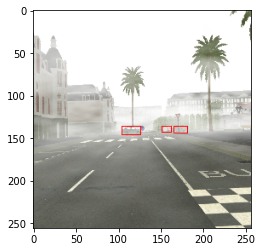

(116, 137) (124, 147)
(130, 136) (139, 146)
[['Car', 116, 124, 137, 147], ['Car', 130, 139, 136, 146]]


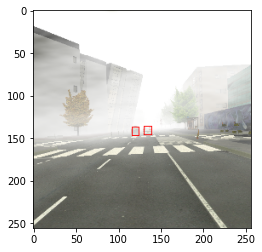

(155, 132) (201, 173)
(137, 132) (155, 152)
(84, 138) (97, 144)
[['Car', 155, 201, 132, 173], ['Car', 137, 155, 132, 152], ['Car', 84, 97, 138, 144]]


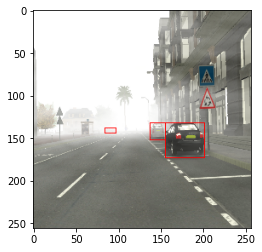

In [9]:
for i in range(5):
    img = all_images[i]
    for j in range(len(all_labels[i])): 
        start_pt = (int(all_labels[i][j][1]),int(all_labels[i][j][3]))  
        end_pt = (int(all_labels[i][j][2]), int(all_labels[i][j][4]))
        print(start_pt,end_pt)
        color = (255,0,0)
        thickness = 1
        img = cv2.rectangle(img,start_pt,end_pt,thickness)
    plt.imshow(img)
    print(all_labels[i])
    plt.show()

In [10]:
np.shape(all_images),np.shape(all_labels)

C:\Users\ArrunPersonal\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


((302, 256, 256, 3), (302,))

In [11]:
''' 
Function to define regions for each instance of an image
'''
def ss_instance(img, all_labels, nr = 2000):
    img_row , img_col = 256,256
    regions = []
    x1 = all_labels[1]; x2 = all_labels[2]; w1 = x2-x1 
    y1 = all_labels[3]; y2 = all_labels[4]; h1 = y2-y1 
    #print(f"X Axis Info : {x1,x2,w1}")
    #print(f"y Axis Info : {y1,y2,h1}")
    for i in range(nr):
        # print(f"Xmin{max(0, x1 - w1//4), x1 + w1//4}")
        # print(f"Xmax{x2 - w1//4, min(x2 + w1//4,img_col)}")
        # print(f"Ymin{max(0, y1 - h1//4), y1 + h1//4}")
        # print(f"Ymax{y2 - h1//4, min(y2 + h1//4,img_row)}")
        if(x1 - w1<0):
            xmin = 0 #x1
        else:
            xmin = np.random.randint(x1-w1, x1 + w1//2) 
        
        if(x2 + w1>img_row):
            xmax = img_row 
        else:
            xmax = np.random.randint(xmin + 1, x2 + w1) 
        
        
        if(y1 - h1<0):
            ymin = 0#y1
        else:
            ymin = np.random.randint(y1 - h1, y1 + h1//2) 
        
        if(y2 + h1 > img_col):
            ymax = img_col#y2
        else:
            ymax = np.random.randint(ymin+1, y2 + h1)
        
        #print(f"xmin,xmax,ymin,ymax = {xmin,xmax,ymin,ymax}")
        #assert(xmax > xmin+1)
        #assert(ymax > ymin+1)
        regions.append([xmin,xmax,ymin,ymax]) 
    
    return regions


''' 
Function to define regions for each instance of an image
'''
def ss_random(img, nr = 10):
    img_row , img_col = np.shape(img)[:2]
    regions = []
    for i in range(nr):
        xmin = np.random.randint(0, img_row//2)
        xmax = np.random.randint(xmin+1,min(xmin+img_row//2,img_row))
        ymin = np.random.randint(0, img_col//2)
        ymax = np.random.randint(ymin+1,min(ymin+img_col//2,img_col))
        regions.append([xmin,xmax,ymin,ymax])
    return regions

In [12]:
'''
Calculates IOU between each result and each instance of an image
'''
def get_iou(b1, b2):
    x_left = max(b1[0], b2[0])
    y_top = max(b1[2], b2[2])
    x_right = min(b1[1], b2[1])
    y_bottom = min(b1[3], b2[3])
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    bb1_area = (b1[1] - b1[0]) * (b1[3] - b1[2])
    bb2_area = (b2[1] - b2[0]) * (b2[3] - b2[2])
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[159, 171, 130, 149]], [[169, 172, 137, 142]], [[158, 169, 132, 135]], [[168, 174, 129, 131]], [[154, 163, 136, 143]], [[142, 153, 128, 136]], [[143, 161, 130, 143]], [[155, 158, 129, 144]], [[152, 153, 128, 131]], [[148, 153, 137, 144]], [[99, 126, 136, 153]], [[112, 148, 141, 147]], [[95, 102, 141, 144]], [[108, 113, 139, 144]], [[81, 105, 141, 155]]]
(256, 256, 3)


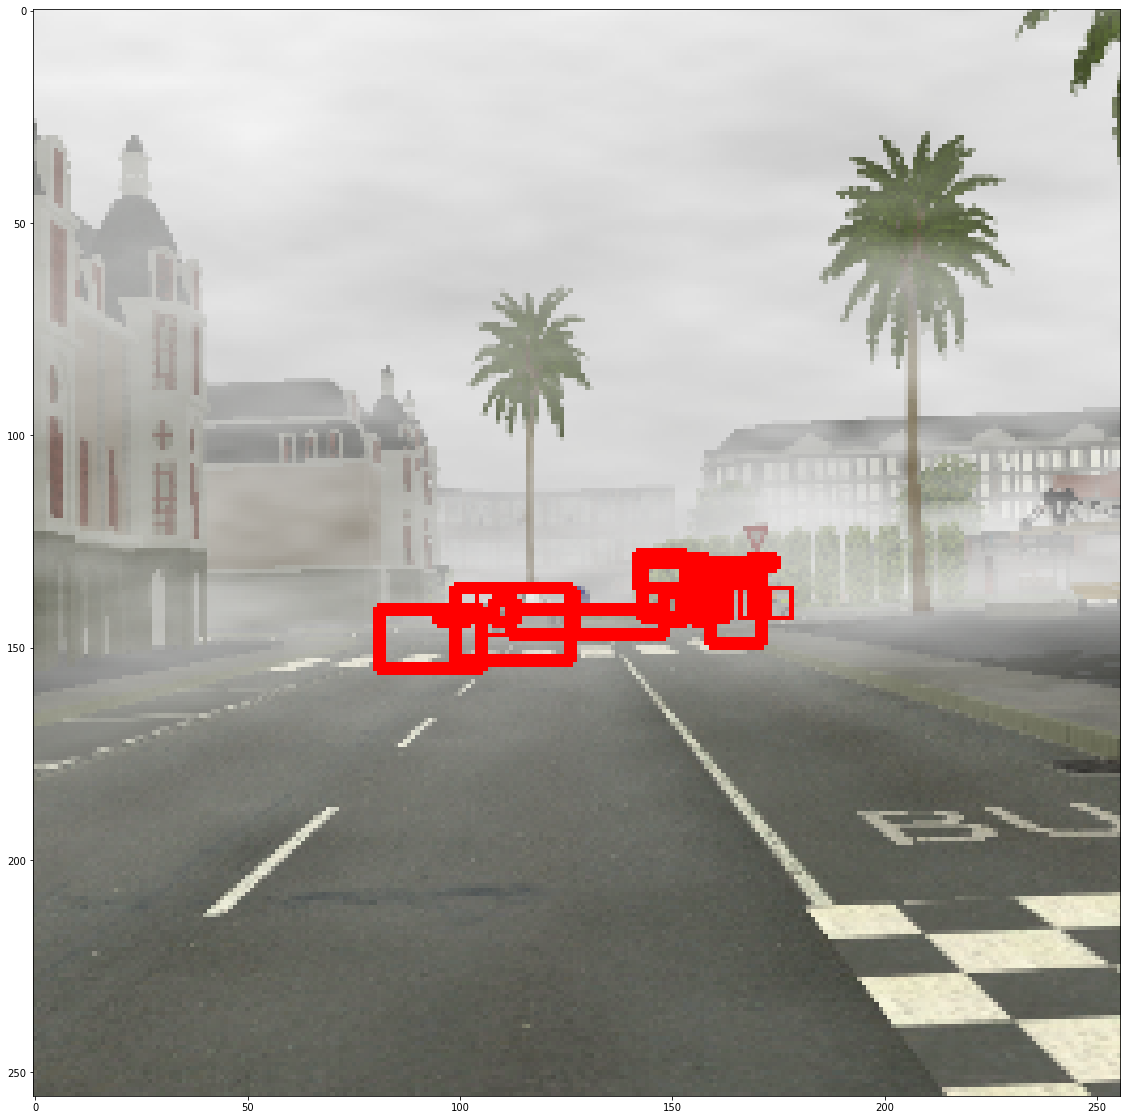

In [13]:
nr = 1
index = 0
img = all_images[index]
sslist = []
for i in range(len(all_labels[index])):
    for j in range(len(all_labels[index][i])):
        sslist.append(ss_instance(img, all_labels[index][i], nr))
        
print(sslist)
#print(sslist, len(sslist))
for i in range(len(sslist)):
    for j in range(len(sslist[i])):
        img = cv2.rectangle(img,(sslist[i][j][0],sslist[i][j][2]),(sslist[i][j][1],sslist[i][j][3]),(255,0,0),2)
print(np.shape(img))
plt.figure(figsize = (20,20))
plt.imshow(img)
plt.show()

In [27]:
train_images = []
train_instance_bbox = []
train_actual_bbox = []
train_class = []
IOU = []
for i in range(len(all_labels)):
    print(f"Image number {i}")
    nr = 1000
    image_name = str(os.listdir(annot_dir)[i].split('.')[0])
    name = images_dir + image_name+".png"
    print(f"Started for image {name}")
    image = all_images[i]
    ssresults = []
    for k in range(len(all_labels[i])):
        #print(all_labels[i][k])
        ssresults.append(ss_instance(image, all_labels[i][k], nr))
    #print(ssresults, len(ssresults))
    fin_box = []
    for j in range(np.shape(ssresults)[1]):
        temp1 = []
        for k in range(np.shape(ssresults)[0]):
            #print(temp[k][j])
            temp1.append(ssresults[k][j])
        fin_box.append(temp1)
    imout = image.copy()
    counter = 0 # set actual train image counters
    flag = 0 # net training process
    
    #print(fin_box)
    for x,result in enumerate(fin_box):
        if flag == 0:
            for gtval in range(len(fin_box[x])):
                #print(result[gtval], all_labels[i][x][1:])
                #print(result[gtval],all_labels[i][gtval][1:])
                iou = get_iou(result[gtval], all_labels[i][gtval][1:])
                #print(iou)
                if counter < nr:
                    if iou> 0.75: #0.6 good results
                        IOU.append(iou)
                        print(iou)
                        timage = np.array(imout)[result[gtval][2]:result[gtval][3],result[gtval][0]:result[gtval][1],0:3]
                        #print(f"Instance : {np.shape(timage)}") 
                        if(np.shape(timage)[0]>1 and np.shape(timage)[0]>1):
                            resized = cv2.resize(timage, (128,128), interpolation = cv2.INTER_AREA)
                            train_images.append(np.array(resized))
                            train_instance_bbox.append(result[gtval])
                            train_actual_bbox.append(all_labels[i][gtval][1:])
                            train_class.append(label_dict.get(all_labels[i][gtval][0]))
                            counter += 1
                          
                else :
                     flag = 1
    #print("All isntances appended")
    bg_box = ss_random(image,4)
    for bg in range(len(bg_box)):
        #print(f"Background boxes = {bg_box}")
        check = True
        for gtval in range(len(all_labels[i])):
            iou = get_iou(bg_box[bg], all_labels[i][gtval][1:])
            if(iou > 0.1):
                #print("Check Pass")
                check = False
                break
        if(check):
            IOU.append(1-iou)
            timage = np.array(image)[bg_box[bg][2]:bg_box[bg][3],bg_box[bg][0]:bg_box[bg][1],0:3]
            print(f"BG : {np.shape(timage)}") 
            resized = cv2.resize(timage, (128,128), interpolation = cv2.INTER_AREA)
            train_images.append(np.array(resized))
            train_instance_bbox.append(bg_box[bg])
            #train_actual_bbox.append(all_labels[i][gtval][1:])
            train_class.append(label_dict.get("BG"))
    print(f"Finished for img {name}")

Image number 0
Started for image C:/Users/ArrunPersonal/Desktop/RG_MiniProject/PHOTOS_FOG_final/019201912.png
0.8396946564885496
0.7521367521367521
0.8396946564885496
BG : (62, 30, 3)
BG : (63, 78, 3)
BG : (102, 34, 3)
BG : (75, 116, 3)
Finished for img C:/Users/ArrunPersonal/Desktop/RG_MiniProject/PHOTOS_FOG_final/019201912.png
Image number 1
Started for image C:/Users/ArrunPersonal/Desktop/RG_MiniProject/PHOTOS_FOG_final/01920192.png
BG : (7, 115, 3)
BG : (66, 59, 3)
BG : (11, 60, 3)
BG : (82, 125, 3)
Finished for img C:/Users/ArrunPersonal/Desktop/RG_MiniProject/PHOTOS_FOG_final/01920192.png
Image number 2
Started for image C:/Users/ArrunPersonal/Desktop/RG_MiniProject/PHOTOS_FOG_final/08291278.png
0.8045977011494253
0.7777777777777778
0.8015267175572519
0.7887323943661971
BG : (6, 9, 3)
BG : (36, 67, 3)
BG : (22, 80, 3)
BG : (25, 44, 3)
Finished for img C:/Users/ArrunPersonal/Desktop/RG_MiniProject/PHOTOS_FOG_final/08291278.png
Image number 3
Started for image C:/Users/ArrunPersona

In [28]:
unique_t, counts_t = np.unique(train_class, return_counts=True)
print(label_dict)
print(unique_t,counts_t)

{'Car': 0, 'BG': 1}
[0 1] [1159 1164]


In [29]:
def preprocess_image_input(input_images):
    input_images = input_images.astype('float32')
    output_ims = tf.keras.applications.resnet50.preprocess_input(input_images)
    return output_ims

In [30]:
train_images = np.array(train_images)
train_class = np.array(train_class)
IOU = np.array(IOU)
train_instance_bbox = np.array(train_instance_bbox)
train_actual_bbox = np.array(train_actual_bbox)
print(np.shape(train_images),type(train_images),np.shape(train_images[0]))
print(np.shape(train_class),type(train_class),np.shape(train_class[0]))
print(np.shape(IOU),type(IOU),np.shape(IOU[0]))
print(np.shape(train_instance_bbox),type(train_instance_bbox),np.shape(train_instance_bbox[0]))
print(np.shape(train_actual_bbox),type(train_actual_bbox),np.shape(train_actual_bbox[0]))

TRAIN_Y = np.concatenate((np.reshape(train_class,(len(train_class),1)),np.reshape(IOU,(len(IOU),1))),axis = 1)
print(np.shape(TRAIN_Y))

(2323, 128, 128, 3) <class 'numpy.ndarray'> (128, 128, 3)
(2323,) <class 'numpy.ndarray'> ()
(2323,) <class 'numpy.ndarray'> ()
(2323, 4) <class 'numpy.ndarray'> (4,)
(1159, 4) <class 'numpy.ndarray'> (4,)
(2323, 2)


In [31]:
train_images[0]

array([[[255.,   0.,   0.],
        [255.,   0.,   0.],
        [255.,   0.,   0.],
        ...,
        [255.,   0.,   0.],
        [255.,   0.,   0.],
        [255.,   0.,   0.]],

       [[255.,   0.,   0.],
        [255.,   0.,   0.],
        [255.,   0.,   0.],
        ...,
        [255.,   0.,   0.],
        [255.,   0.,   0.],
        [255.,   0.,   0.]],

       [[255.,   0.,   0.],
        [255.,   0.,   0.],
        [255.,   0.,   0.],
        ...,
        [255.,   0.,   0.],
        [255.,   0.,   0.],
        [255.,   0.,   0.]],

       ...,

       [[255.,   0.,   0.],
        [255.,   0.,   0.],
        [255.,   0.,   0.],
        ...,
        [255.,   0.,   0.],
        [255.,   0.,   0.],
        [255.,   0.,   0.]],

       [[255.,   0.,   0.],
        [255.,   0.,   0.],
        [255.,   0.,   0.],
        ...,
        [255.,   0.,   0.],
        [255.,   0.,   0.],
        [255.,   0.,   0.]],

       [[255.,   0.,   0.],
        [255.,   0.,   0.],
        [255.,  

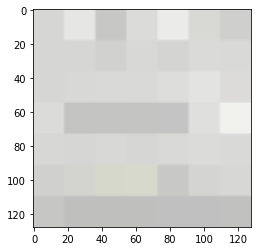

0


In [51]:
ind = 109
plt.imshow(train_images[ind])
plt.show()
print(train_class[ind])

In [22]:
print(len(train_images))
print(len(train_class))
print(len(IOU))
print(len(train_instance_bbox))
print(len(train_actual_bbox))

2359
2359
2359
2359
1194


## Final Classifier Model

In [23]:
'''
Feature Extraction is performed by ResNet50 pretrained on imagenet weights. 
Input size is 128 x 128.
'''

def feature_extractor(inputs):

    feature_extractor = tf.keras.applications.resnet.ResNet50(input_shape=(128, 128, 3),
                                               include_top=False,
                                               weights='imagenet')(inputs)#weights="/gdrive/MyDrive/ExDark/ModelWeights/Resnet50_COCO_Pretrained_best.h5")(inputs) #
    return feature_extractor


'''
Defines final dense layers and subsequent softmax layer for classification.
'''
def classifier_confidence(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    
    x1 = tf.keras.layers.Dense(len(label_dict), activation="softmax", name="classification")(x)
    x2 = tf.keras.layers.Dense(128, activation="relu")(x)
    x2 = tf.keras.layers.Dense(1, activation="sigmoid", name="confidence")(x2)
    return x1 ,x2

'''
Connect the feature extraction and "classifier" layers to build the model.
'''
def final_model(inputs):

    resnet_feature_extractor = feature_extractor(inputs)
    #class_out = classifier_confidence(resnet_feature_extractor)  
    class_out , conf_out = classifier_confidence(resnet_feature_extractor)

    return class_out, conf_out

'''
Define the model and compile it. 
Use Stochastic Gradient Descent as the optimizer.
Use Sparse Categorical CrossEntropy as the loss function.
'''
def define_compile_model():

    inputs = tf.keras.layers.Input(shape=(128,128,3))
    classification_output, confidence_output = final_model(inputs) 
    model = tf.keras.Model(inputs=inputs, outputs = [classification_output, confidence_output])  
    return model


model = define_compile_model()
model.summary()
model.compile(optimizer='SGD', loss= {"classification": keras.losses.sparse_categorical_crossentropy, "confidence": "mse"}, metrics = {"classification": 'accuracy', "confidence": tf.keras.metrics.RootMeanSquaredError()})

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 resnet50 (Functional)          (None, 4, 4, 2048)   23587712    ['input_1[0][0]']                
                                                                                                  
 global_average_pooling2d (Glob  (None, 2048)        0           ['resnet50[0][0]']               
 alAveragePooling2D)                                                                              
                                                                                              

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
#TRAIN_Y = tuple((TRAIN_Y[:,0],TRAIN_Y[:,1]))
#TRAIN_Y = tuple((train_class.T, IOU.T))
train_x, test_x, train_y, test_y = train_test_split(train_images, TRAIN_Y,random_state = 10)
train_y = tuple((train_y[:,0],train_y[:,1]))
test_y = tuple((test_y[:,0],test_y[:,1]))
print(type(train_y))
print(np.shape(train_x))
print(len(train_x))
print(len(test_y))

<class 'tuple'>
(1769, 128, 128, 3)
1769
2


In [27]:
del train_images
del train_class
del IOU

In [28]:
print(np.shape(train_x))
print(np.shape(train_y))

(1753, 128, 128, 3)
(2, 1753)


In [39]:
history = model.fit(train_x, train_y, epochs=20,verbose = 1,batch_size = 16,validation_data=(test_x,test_y))

Epoch 1/20
110/110 [==============================] - 11s 68ms/step - loss: 0.6979 - classification_loss: 0.6765 - confidence_loss: 0.0214 - classification_accuracy: 0.6155 - confidence_root_mean_squared_error: 0.1462 - val_loss: 0.7090 - val_classification_loss: 0.6992 - val_confidence_loss: 0.0098 - val_classification_accuracy: 0.5111 - val_confidence_root_mean_squared_error: 0.0990
Epoch 2/20
110/110 [==============================] - 7s 59ms/step - loss: 0.5772 - classification_loss: 0.5676 - confidence_loss: 0.0096 - classification_accuracy: 0.6823 - confidence_root_mean_squared_error: 0.0981 - val_loss: 0.7064 - val_classification_loss: 0.6941 - val_confidence_loss: 0.0124 - val_classification_accuracy: 0.4974 - val_confidence_root_mean_squared_error: 0.1113
Epoch 3/20
110/110 [==============================] - 7s 59ms/step - loss: 0.5015 - classification_loss: 0.4936 - confidence_loss: 0.0078 - classification_accuracy: 0.7410 - confidence_root_mean_squared_error: 0.0884 - val_lo

In [45]:
model.save('C:/Users/ArrunPersonal/Desktop/RG_MiniProject/Resnet50_2class_30epch.h5')

In [40]:
history.history.keys()

dict_keys(['loss', 'classification_loss', 'confidence_loss', 'classification_accuracy', 'confidence_root_mean_squared_error', 'val_loss', 'val_classification_loss', 'val_confidence_loss', 'val_classification_accuracy', 'val_confidence_root_mean_squared_error'])

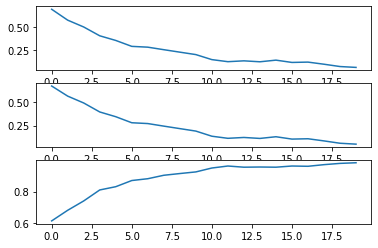

In [41]:
plt.subplot(3,1,1).plot(history.history['loss'])
plt.subplot(3,1,2).plot(history.history['classification_loss'])
plt.subplot(3,1,3).plot(history.history['classification_accuracy'])
plt.show()

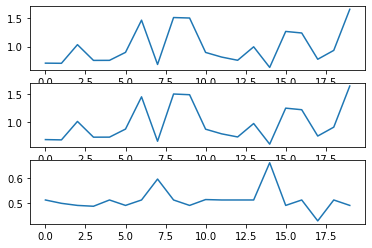

In [42]:
plt.subplot(3,1,1).plot(history.history['val_loss'])
plt.subplot(3,1,2).plot(history.history['val_classification_loss'])
plt.subplot(3,1,3).plot(history.history['val_classification_accuracy'])
plt.show()

In [43]:
len(test_y[0])

585

In [44]:
from sklearn.metrics import *

In [45]:
test_x[20]

array([[[-103.63018 , -116.458595, -123.36983 ],
        [-103.63018 , -116.458595, -123.36983 ],
        [-103.63018 , -116.458595, -123.36983 ],
        ...,
        [-103.66474 , -116.49512 , -123.40708 ],
        [-103.66474 , -116.49512 , -123.40708 ],
        [-103.66474 , -116.49512 , -123.40708 ]],

       [[-103.63018 , -116.458595, -123.36983 ],
        [-103.63018 , -116.458595, -123.36983 ],
        [-103.63018 , -116.458595, -123.36983 ],
        ...,
        [-103.66474 , -116.49512 , -123.40708 ],
        [-103.66474 , -116.49512 , -123.40708 ],
        [-103.66474 , -116.49512 , -123.40708 ]],

       [[-103.63018 , -116.458595, -123.36983 ],
        [-103.63018 , -116.458595, -123.36983 ],
        [-103.63018 , -116.458595, -123.36983 ],
        ...,
        [-103.66474 , -116.49512 , -123.40708 ],
        [-103.66474 , -116.49512 , -123.40708 ],
        [-103.66474 , -116.49512 , -123.40708 ]],

       ...,

       [[-103.80824 , -116.643524, -123.54661 ],
        [-1

In [46]:
ind = np.arange(len(test_y[0]))
pred = model.predict(np.array(test_x[ind]))
pred
act_preds = (np.argmax(pred[0],axis=1))

print(act_preds)

acc = 0
for i in ind:
    act_lab = get_key_dict[test_y[0][i]]
    pred_lab = get_key_dict[act_preds[i]]
    if(act_lab==pred_lab):
        acc +=1
    print(f"Predicted Label = {pred_lab} and Expected Label = {act_lab}")
    
print("Labelling Accuracy = ",acc/i)

19/19 [==============================] - 1s 26ms/step
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1